<a href="https://colab.research.google.com/github/josealvarez97/The-Ultimate-Guide-to-Write-Your-First-CFD-Solver/blob/main/The_Ultimate_Guide_to_Write_Your_First_CFD_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What have we learned about Navier-Stokes and CFD?
**by Jose Alvarez and Mahmud Nobe** 

So far in this unit, this is what we have covered:

* **Session 7**.  
During the first half of session 7, we familiarized ourselves with the physical concepts relevant to fluid dynamics, such as the **conservation of mass** and the **balance of momentum**. We reviewed calculus concepts such as the **divergence operator** and clarified doubts about the notation used in the Navier-Stokes equations.   During the second half, we discussed how to **discretize the partial differential equations** in the model.

* **Session 8**  
In a way, session 8 was about algorithms. We wrote pseudocode and practiced how to
  - initialize the data structures and set up the global variables for the numerical solver;
  - set up the initial and boundary conditions;
  - proceed to compute the "starred" velocity, solve for the pressure Poisson equation, and update the velocity field; and
  - how to produce and interpret a visualization.


* **Session 9**.  
The learning goal of session 9 is to make you capable of implementing your first CFD solver. To achieve this, we will assign the following three main resources:
  * Deshmukh, G. (2021). _Computational Fluid Dynamics using Python: Modeling Laminar Flow_. Towards Data Science. Retrieved from https://towardsdatascience.com/computational-fluid-dynamics-using-python-modeling-laminar-flow-272dad1ebec  
  * Owkes, M. (2020). _A guide to writing your first CFD solver_. Retrieved from https://www.montana.edu/mowkes/research/source-codes/GuideToCFD_2020_02_28_v2.pdf  
  * Barba, Lorena A., and Forsyth, Gilbert F. (2018). _CFD Python: the 12 steps to Navier-Stokes equations [Step 11: Cavity Flow with Navier–Stokes]_. Journal of Open Source Education. Retrieved from https://github.com/barbagroup/CFDPython/blob/master/lessons/14_Step_11.ipynb


Barba et. al. (2018) will be our main source of reference for sesion 9. We liked this implementation because it is the most straightforward, and we considered their approach to discretize the Laplacian of the pressure and solve the Poisson equation to be very pedagogically effective.

## The ultimate guide to write your first CFD solver by Alvarez & Mahmud (2021) 

Nonetheless, one of the best ways to learn is to contrast two different ways to do the same task. In this guide, we took inspiration from the approach by [Owkes (2020)](https://www.montana.edu/mowkes/research/source-codes/GuideToCFD_2020_02_28_v2.pdf), but make a few simplifying assumptions:

* Accodring to Owkes (2020, p. 2), "_A staggered grid is used to store the variables where the pressure is stored at the cell center and the velocities are stored at the cell faces. This, **possibly odd**, choice is made since it allows for the solution to
have a tight coupling between pressure and the velocity and has been found to be the preferred methodology._" [emphasis mine] **We strongly disagree with this.** We believe this to be the wrong way of thinking about the problem. We prefer to think of a mesh as a net of points, i.e., we do not distinguish between the the border of a cell and its center.
* As a consequence, we do not need to overcomplicate the formulas as Owkes (2020) does in equations (11), (15), and (23/24) of his paper. 

Furthermore, we also have our differences with Barba et. al. (2012):
  * You may notice that one important consideration we have for incompressible CFD solver is how to incorporate the mass conservation with the momentum conservation equation. Both Owekes and Barba connects them using a pressure poison equation with a source term. As we went over last class, Owekes separates the momentum equation in predictor and corrector steps. Then taking the divergence of the corrector steps, they found the source term in pressure poisson equation as, $b = \frac{\rho}{\Delta t} \nabla \cdot \mathbf{u}^*$. In this study guide we would follow this approch.
  * On the other hand, Barba et al. first write down the momentum equation separately for two component (u and v). Then they multiply both side of u-momentum equation with $\frac{\partial}{\partial x}$ and similarly both side of v-momentum equation with $\frac{\partial}{\partial y}$. Then they added these two equations and use mass conservation equation to simplify everything. Finally the source term they found for the pressure poisson equation is, 
$$b = -\rho \left( \frac{\partial u}{\partial x}^2 + 2 \frac{\partial u}{\partial y} \frac{\partial v}{\partial x} + \frac{\partial v}{\partial y}^2\right)$$
One advantage in this approach is we do not need to consider the predictor, corrector steps, (i.e. no extra calculation of $u^*, v^*$) and we can only use the two momentum equation and this pressure poisson equation to solve for CFD. But the calculation to get the source term becomes very messier (if you checked the optional video, then you know that).

  * Which approach do you think is better? **For this guide, you'll realize that we took much of the mathematical model of Owkes (2020) and much of the numerical algorithm of Barba et. al. (2012).**

  * We did love the use of **vectorized operations** in Barba et. al. (2012) and the way they define boundary conditions. Our only addition to their approach is the use of **reusable functions** for finite differences of 1st-order and 2nd-order. (We also preferred to use **centered differences** as opposed to forward  differences whenever possible.) We realized  this leads to much more cleaner code that is more readable without sacrificing efficiency in most instances.

# Overview of mathematical model

A partial differential equation is an equation of the form:

$$f(u, \frac{\partial u}{\partial x}, ..., \partial^n_x u, \frac{\partial u}{\partial y}, ..., \partial^n_y u, x, y)=0$$
It is important to remember that there is nothing different about Navier-Stokes. We'll try to express the model in this basic form whenever possible. We hope that this will help to clarify any remaining doubts about the notation.



## Continuity equation (conservation of mass)

$$\nabla \mathbf{u}=0$$

What this is actually saying:

$$\frac{\partial u}{\partial x} + \frac{\partial u}{\partial y} = 0$$

## Conservation (balance) of momentum

$$\frac{\partial \mathbf{u}}{\partial t} + \mathbf{u}\cdot \nabla \mathbf{u} = - \frac{1}{\rho} \nabla p + \nu \nabla^2\mathbf{u}$$

What this is actually saying:

$$\frac{\partial u}{\partial t} +  \left( u \frac{\partial u}{\partial x}+ v\frac{\partial u}{\partial y} \right) = - \frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left(\frac{\partial^2 u}{\partial^2 x} + \frac{\partial^2 u}{\partial^2 y}\right)$$


$$\frac{\partial v}{\partial t} + \left( u \frac{\partial v}{\partial x}+ v\frac{\partial v}{\partial y} \right) = - \frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left(\frac{\partial^2 v}{\partial^2 x} + \frac{\partial^2 v}{\partial^2 y}\right)$$


# Initialize global variables and data structures

In [ ]:
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import sys

In [ ]:
nx = 41
x_max = 2 
x_min = 0

ny = 41
y_max = 2
y_min = 0

nt = 500
dx = (x_max - x_min) / (nx - 1)
dy = (y_max - y_min) / (ny - 1)

x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, x_max, ny)
X, Y = np.meshgrid(x,y)

rho = 1 # density
nu = .1 # viscosity coefficient
dt = .001 # timestep

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))


# Define boundary conditions

There are two main usual types of boundary conditions: **Dirichlet (or "fixed")** boundary conditions and **Neumann (or "second-type")** boundary conditions. The former specifies the values of the solution at the boundaries of the domain, and the latter the values of the derivative at the boundaries of the domain.

If you read section 8 in Owkes (2020), you'll realize that his goal is to achieve a $u_{top}=0$ boundary condition. (He means a Dirichlet boundary condition, i.e., an specific value of the function.) Owkes (2020) explains how he achieved this in section 8, but in our opinion, his approach is unnecessarily cumbersome. At least, he needs to account for the fact that his discretization of the velocity field does not coincide with the boundaries of the continuous domain. Because Barba et. al. (2012) did things differently (their discretization coincides with the boundaries of the continuous domain), they don't have that problem: they can go ahead and define the (Dirichlet) boundary conditions "directly."

In [ ]:
def set_velocity_boundary(u,v):
    # Velocidty boundary conditions (Dirichlet or "fixed")
    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0
    u[-1, :] = 1    # set velocity on cavity lid equal to 1
    v[0, :]  = 0
    v[-1, :] = 0
    v[:, 0]  = 0
    v[:, -1] = 0

    return u, v

The following implementation of Neumann boundary conditions for the pressure comes from Barba et. al. (2012). You'll realize that is also very straightforward:

In [ ]:
def set_pressure_boundary(p):
    # Pressure boundary conditions (Neumann or "second-type")
    '''
    Trick question: Would the approach below break depending on 
    whether you use forward, backward, or centered differences?
    Why or why not?
    '''
    p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
    p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
    p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
    # Pressure boundary conditions (Dirichlet or "fixed")
    p[-1, :] = 0        # p = 0 at y = 2

    return p

The intuition for the previous is nothing out of this world: If you want to set up Dirichlet (or "fixed") boundary conditions, define the values directly on the boundaries (no joke, Einstein); if you want to set up Neumann (or "second-type") boundary conditions, make sure that the rate of change across the boundaries is such that the finite difference approximation matches the desired value. 

**Note that for Neumann boundary condition, the boundary value of pressure depends on the pressure of the nearest column/row. So it changes in every step.** Thus it is always a best practice to include the boundary conditions inside of the final update function. But note that if we have a Dirichlet or fixed boundary condition, then it will work even if we just define the boundary condition once and not have that inside of our update function. 

# Discretize the domain: Approximate derivatives with finite differences

In [ ]:
def diff_1st_x(f,dx):
  return (f[1:-1, 2:] - f[1:-1,0:-2])/(2*dx)

def diff_1st_y(f,dy):
  return (f[2:, 1:-1] - f[0:-2,1:-1])/(2*dy)

def diff_2nd_x(f,dx):
  return (
      # f(i-1,j) + 2*f(i,j) + f(i+1,j) 
      (f[1:-1,0:-2] - 2*f[1:-1,1:-1] + f[1:-1,2:])
      /dx**2
      ) 
  
def diff_2nd_y(f,dy):
  return (
      # f(i,j-1) + 2*f(i,j) + f(i,j+1) 
      (f[0:-2,1:-1] - 2*f[1:-1,1:-1] + f[2:,1:-1])
      /dy**2
      )

def laplacian(f, dx, dy):
  return (diff_2nd_x(f, dx) + 
          diff_2nd_y(f, dy))

# Temporal discretization

Appreciating the partial derivatives explicitly is wonderful, but it can get pretty hard to express the ideas without the compact notation: 

$$\frac{\mathbf{u}^{n+1}-\mathbf{u}^n}{\Delta t}=-\frac{1}{\rho}\nabla p^{n+1} - \mathbf{u}^n \cdot \nabla \mathbf{u}^n + \nu \nabla ^2 \mathbf{u}^n$$

Which we can rewrite as:


$$\mathbf{u}^{n+1}=\left( -\frac{1}{\rho}\nabla p^{n+1}  - \mathbf{u}^n \cdot \nabla \mathbf{u}^n + \nu \nabla ^2 \mathbf{u}^n \right)\Delta t + \mathbf{u}^n $$

Which is actually also easy to breakdown (take note of the the slight abuse of notation, $\frac{\partial u^n}{\partial x}=\frac{u^n(i+1,j)-u^n(i-1,j}{2\Delta x}$, which conveys the finite difference approximation at time $n$):

$$u^{n+1} = \left( - \frac{1}{\rho} \frac{p^{n+1}-p^n}{\Delta x} -\left( u^n \frac{\partial u^n}{\partial x}+ v^n\frac{\partial u^n}{\partial y} \right) + \nu \left(\frac{\partial^2 u^n}{\partial^2 x} + \frac{\partial^2 u^n}{\partial^2 y}\right) \right) \Delta t + u^n$$

$$v^{n+1} = \left( - \frac{1}{\rho} \frac{p^{n+1}-p^n}{\Delta y} -\left( u^n \frac{\partial v^n}{\partial x}+ v^n\frac{\partial v^n}{\partial y} \right) + \nu \left(\frac{\partial^2 v^n}{\partial^2 x} + \frac{\partial^2 v^n}{\partial^2 y}\right) \right) \Delta t + v^n$$

In [ ]:
def compute_vel_star(un, vn, dx, dy, dt):
  u_star = un.copy()
  v_star = vn.copy()

  # Equation (7), Owkes (2020)
  u_star[1:-1,1:-1] = (nu * laplacian(un, dx, dy) -
                         (un[1:-1, 1:-1]*diff_1st_x(un,dx) + 
                          vn[1:-1, 1:-1]*diff_1st_y(un,dy))
                      )*dt + un[1:-1, 1:-1]
  '''
  Pre-class challenge:
  * Can you rewrite this function 
  to avoid the repetitive lines of code?
  * If so, do your changes sacrifice 
  efficiency for readibility? Why or why not?
  '''

  # Equation (12), Owkes (2020)
  v_star[1:-1,1:-1] = (nu * laplacian(vn, dx, dy) -
                         (un[1:-1, 1:-1]*diff_1st_x(vn,dx) + 
                          vn[1:-1, 1:-1]*diff_1st_y(vn,dy))
                      )*dt + vn[1:-1, 1:-1]
  
  return u_star, v_star

## What about the pressure term? 

### $\mathbf{u}^*$ and the _predictor step_.

You may have noticed that we dropped the pressure term in the previous cell, and instead calculated $u^*$ and $v^*$. This is known as the **_predictor step_**:

$$\mathbf{u}^*=\left(- \mathbf{u}^n \cdot \nabla \mathbf{u}^n + \nu \nabla ^2 \mathbf{u}^n \right)\Delta t + \mathbf{u}^n $$


This is what we actually implemented in our code above, the preditor step or $\mathbf{u}^*$. It's really nothing more than the **_value of the velocity without the influence of pressure_**.

We will update $\mathbf{u}^{n+1}$ from $\mathbf{u}^*$ later (the **corrector step**). Before, we need to compute the pressure with the Poisson Equation.

# The pressure Poisson Equation



The **pressure Poisson Equation** is (see Owkes (2020)):

$$ \nabla^2 p^{n+1} = -\frac{\rho}{\Delta t} \nabla \cdot \mathbf{u}^*$$

Except that is not true. As it turns, there is a typo in equation (6) of Owkes (2020). The right hand side should be positive, as follows:

$$\nabla ^2 p^{n+1} = \frac{\rho}{\Delta t} \nabla \cdot \mathbf{u}^*$$



This took us a while to catch in our the code (try to change the sign and you'll see what happens). Our program is more similar to Barba et. al. (2012), but this bit is really based on the model that Owkes (2020) follows for the **source term**, which he calls $\mathbf{R}$ instead of $b$. Appendix A shows how to derive the pressure Poisson Equation in terms of the starred velocity correctly. 

Anyways, here's how it continues to break down:

$$\frac{\partial ^2 p^{n+1}}{\partial x^2}+ \frac{\partial ^2 p^{n+1}}{\partial y^2} = \frac{\rho}{\Delta t} \left( \frac{\partial u^*}{\partial x} + \frac{\partial v^*}{\partial y} \right)$$

We will combine the approaches of Owkes (2020) and Barba et. al. (2012). The divergence operator applied to the predictor step $\mathbf{u}^*$ allows for the code to follow the math as in Owkes (2020) more closely, while the discretization of the Laplacian of the pressure as in Barba et. al. (2012) allows for a more pedagogically intuitive way to solve the Poisson Equation:

Let $b = \frac{\rho}{\Delta t} \left( \frac{\partial u^*}{\partial x} + \frac{\partial v^*}{\partial y} \right)$

In [ ]:
def get_b(u_star, v_star, dx, dy, dt):
  '''
  Right hand side of equation (6), Owkes (2020)
  '''
  # b comes from starred velocities, which have boundary
  # conditions (the starred velocity is just the velocity
  # without the influence of pressure, so it still maintains
  # the boundary conditions of the velocity),  
  # but b does not really have boundary conditions of its own.
  # (P.S. Important point is how the value is used in pressure_poisson function,
  # i.e., `b[1:-1, 1:-1]` or simply `b`)
  # b = np.zeros((ny, nx))

  # (Divergence of vector-valued function)
  divergence_vel_star = (diff_1st_x(u_star,dx) + 
                         diff_1st_y(v_star,dy))
  # b[1:-1,1:-1] = (1*rho/dt) * divergence_vel_star
  b = (rho/dt) * divergence_vel_star

  return b

then

$$\frac{\partial ^2 p^{n+1}}{\Delta x^2}+ \frac{\partial ^2 p^{n+1}}{\Delta y^2} = b$$

$$\frac{p^{n+1}(i-1,j) - 2p^{n+1}(i,j) + p^{n+1}(i+1,j)}{\Delta x^2}+ \frac{p^{n+1}(i-1,j) - 2p^{n+1}(i,j) + p^{n+1}(i+1,j)}{\Delta y^2} = b$$

$$\frac{\left(p^{n+1}(i-1,j) - 2p^{n+1}(i,j) + p^{n+1}(i+1,j)\right) \Delta y^2 + \left( p^{n+1}(i-1,j) - 2p^{n+1}(i,j) + p^{n+1}(i+1,j) \right) \Delta x^2}{\Delta x^2 \Delta y^2} = b$$

$$\left(p^{n+1}(i-1,j) - 2p^{n+1}(i,j) + p^{n+1}(i+1,j)\right) \Delta y^2 + \left( p^{n+1}(i-1,j) - 2p^{n+1}(i,j) + p^{n+1}(i+1,j) \right) \Delta x^2 = b^n(i,j) \Delta x^2 \Delta y^2$$

$$p^{n+1}(i-1,j)\Delta y^2 - 2p^{n+1}(i,j)\Delta y^2 + p^{n+1}(i+1,j)\Delta y^2  + p^{n+1}(i-1,j)\Delta x^2 - 2p^{n+1}(i,j)\Delta x^2 + p^{n+1}(i+1,j)\Delta x^2   = b^n(i,j) \Delta x^2 \Delta y^2$$

$$ - 2\left( \Delta y^2 + \Delta x^2 \right) p^{n+1}(i,j)    = - \Delta y^2 \left(p^{n+1}(i-1,j) + p^{n+1}(i+1,j) \right) - \Delta x^2 \left( p^{n+1}(i-1,j) + p^{n+1}(i+1,j) \right) + b^n(i,j) \Delta x^2 \Delta y^2$$


finally 
$$ p^{n+1}(i,j)    = \frac{\Delta y^2 \left(p^{n+1}(i-1,j) + p^{n+1}(i+1,j) \right) + \Delta x^2 \left( p^{n+1}(i-1,j) + p^{n+1}(i+1,j) \right) - b^n(i,j) \Delta x^2 \Delta y^2}{2\left( \Delta y^2 + \Delta x^2 \right) }$$

In [ ]:
def pressure_poisson(p, b, dx, dy):  
  pn = p.copy()

  # (pn(i-1,j) + pn(i+1,j)) * dy**2 
  term1 = (pn[1:-1,0:-2] + pn[1:-1,2:]) * dy**2
  # (pn(i,j-1) + pn(i,j+1)) * dx**2
  term2 = (pn[0:-2,1:-1] + pn[2:,1:-1]) * dx**2
  # term 3 is -b * dx^2  * dy^2
  term3 = -(b * (dx**2 * dy**2))

  p[1:-1,1:-1] = (
      (term1 + term2 + term3)
      / (2*(dx**2+dy**2))
  )
  
  # reset boundary condition
  p = set_pressure_boundary(p)
  
  return p

# Update velocities: _**Corrector step**_

Finally, we have the pressure we were missing. Now we can update the velocity from $\mathbf{u}^*$ into $\mathbf{u}^{n+1}$.

Recall that the corrector step formula from Owkes (2020) is:

$$\mathbf{u}^{n+1}=\Delta t\left( - \frac{1}{\rho}  \nabla p^{n+1}\right) + \mathbf{u}^*$$

which can be broken down as:

$$u^{n+1}=-\frac{\Delta t}{\rho}\left(\frac{\partial p^{n+1}}{\partial x} \right) + u^*$$
$$v^{n+1}=-\frac{\Delta t}{\rho}\left( \frac{\partial p^{n+1}}{\partial y}\right) + v^*$$




In [ ]:
def corrector_step(u_star, v_star, p, dx, dy, dt, rho):
  u = np.empty_like(u_star)
  v = np.empty_like(u_star)
  
  u[1:-1,1:-1] = (-dt/rho)*(diff_1st_x(p, dx)) + u_star[1:-1,1:-1]
  v[1:-1,1:-1] = (-dt/rho)*(diff_1st_y(p, dy)) + v_star[1:-1,1:-1]

  # reset velocity boundary
  u, v = set_velocity_boundary(u, v)

  return u, v

# Run simulation

In [ ]:
def simulate_cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
  for n in range(nt):
    un = u.copy()
    vn = v.copy()

    # Predictor step (starred velocities)
    u_star, v_star = compute_vel_star(un, vn, dx, dy, dt)

    # Solve pressure Poisson Equation
    b = get_b(u_star, v_star, dx, dy, dt)
    p = pressure_poisson(p, b, dx, dy)

    # Corrector step (update velocities)
    u, v = corrector_step(u_star, v_star, p, dx, dy, dt, rho)

  return u, v, p

Recall that all of the necessary variables were initialized in the top of the notebook.

In [ ]:
u, v, p = simulate_cavity_flow(1000, u, v, dt, dx, dy, p, rho, nu)

# Visualize results

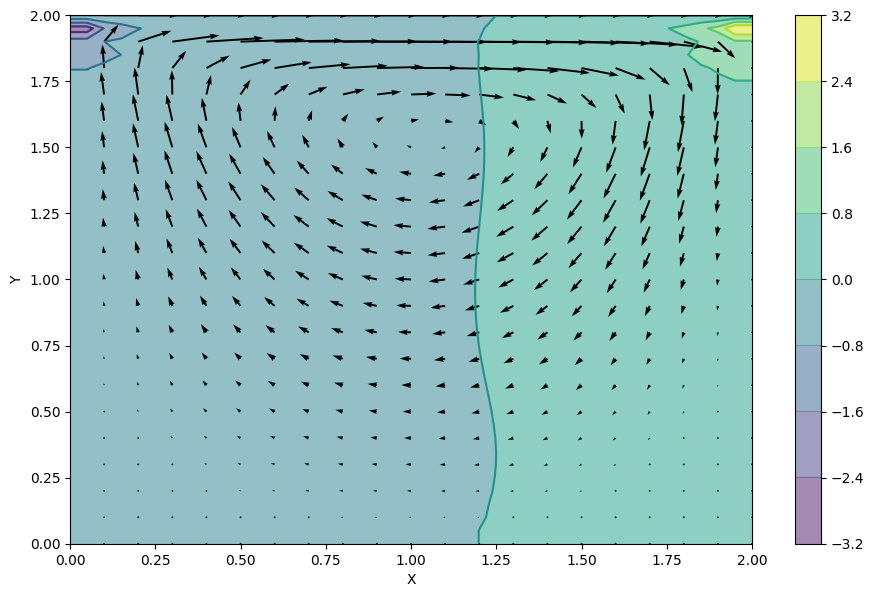

In [ ]:
fig = plt.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
plt.colorbar()
# plotting the pressure field outlines
plt.contour(X, Y, p, cmap=cm.viridis)
# plotting velocity field
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
plt.xlabel('X')
plt.ylabel('Y');

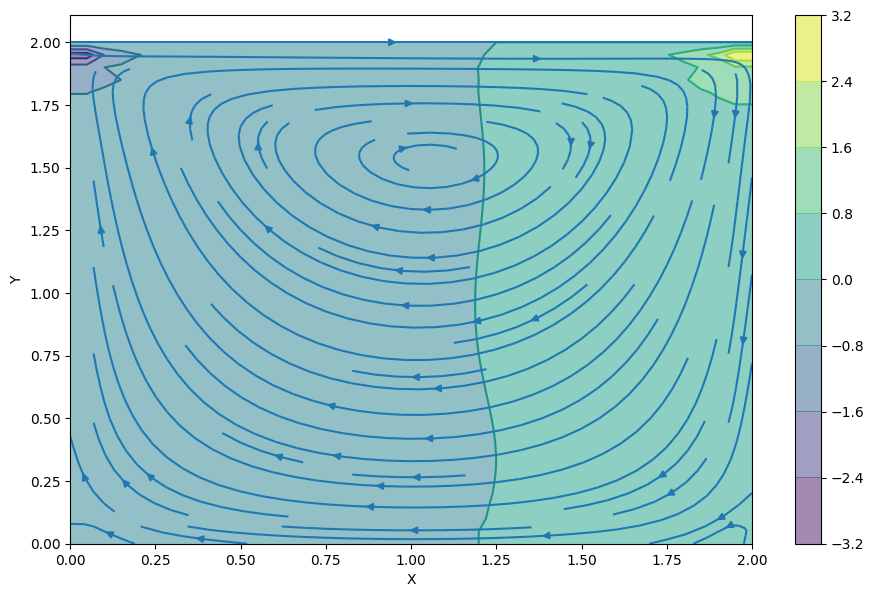

In [ ]:
fig = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
plt.colorbar()
plt.contour(X, Y, p, cmap=cm.viridis)
plt.streamplot(X, Y, u, v)
plt.xlabel('X')
plt.ylabel('Y');

# References: 
Owkes, M. (2020). A guide to writing your first CFD solver. 

Barba, Lorena A., and Forsyth, Gilbert F. (2018). CFD Python: the 12 steps to Navier-Stokes equations [Step 11: Cavity Flow with Navier–Stokes]. Journal of Open Source Education.

# Appendix A: 
Pressure Poisson equation by Owekes

Corrector Term:

\begin{align}
    \mathbf{u}^{n+1} - \mathbf{u}^*=\Delta t\left( - \frac{1}{\rho}  \nabla p^{n+1}\right)\\
    \mathbf{u}^{n+1} - \mathbf{u}^*= - \frac{\Delta t}{\rho}  \nabla p^{n+1}
\end{align}

Taking the divergence of both side,
\begin{align}
    \nabla \cdot \mathbf{u}^{n+1} - \nabla \cdot \mathbf{u}^*= - \frac{\Delta t}{\rho}  \nabla^2 p^{n+1}
\end{align}

From mass conservation, we know that,

\begin{align}
    \nabla \cdot \mathbf{u}^{n+1} &= 0\\
    \therefore \nabla \cdot \mathbf{u}^* &= \frac{\Delta t}{\rho}  \nabla^2 p^{n+1}\\
    \nabla^2 p^{n+1} &= \frac{\rho}{\Delta t} \nabla \cdot \mathbf{u}^*  
\end{align}

